**Import Libraries**

In [1]:
pip install transformers datasets gradio pyarrow evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec

In [2]:
pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 103.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import torch
import gradio as gr
import evaluate
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback)
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["WANDB_DISABLED"] = "true"

2025-04-26 13:03:43.241976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745672623.432783      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745672623.491763      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Load Dataset**

In [4]:
# Load Dataset from Hugging Face (Parquet via Pandas)
splits = {
    'train': 'plain_text/train-00000-of-00001.parquet',
    'test': 'plain_text/test-00000-of-00001.parquet'
}

df_train = pd.read_parquet("hf://datasets/fancyzhx/yelp_polarity/" + splits["train"])
df_test  = pd.read_parquet("hf://datasets/fancyzhx/yelp_polarity/" + splits["test"])

In [5]:
df_train.head()

,text,label
0,"Unfortunately, the frustration of being Dr. Go...",0
1,Been going to Dr. Goldberg for over 10 years. ...,1
2,I don't know what Dr. Goldberg was like before...,0
3,I'm writing this review to give you a heads up...,0
4,All the food is great here. But the best thing...,1


In [6]:
df_train.shape

(560000, 2)

In [7]:
df_test.head()

,text,label
0,"Contrary to other reviews, I have zero complai...",1
1,Last summer I had an appointment to get new ti...,0
2,"Friendly staff, same starbucks fair you get an...",1
3,The food is good. Unfortunately the service is...,0
4,Even when we didn't have a car Filene's Baseme...,1


In [8]:
df_test.shape

(38000, 2)

**Preprocessing**

In [9]:
import re
import string

def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)   # remove HTML tags
    text = re.sub(r'\d+', ' ', text)     # remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.lower()  # lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

In [10]:
df_train["text"] = df_train["text"].apply(clean_text)
df_test["text"]  = df_test["text"].apply(clean_text)

**Tokenization**

In [11]:
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset  = Dataset.from_pandas(df_test)

In [13]:
# Apply Tokenization
def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

train_dataset = train_dataset.map(tokenize_batch, batched=True)
test_dataset  = test_dataset.map(tokenize_batch, batched=True)

Map:   0%|          | 0/560000 [00:00<?, ? examples/s]

Map:   0%|          | 0/38000 [00:00<?, ? examples/s]

In [14]:
# Remove Unnecessary Columns
train_dataset = train_dataset.remove_columns(["text"])
test_dataset  = test_dataset.remove_columns(["text"])

In [15]:
# Set Format to PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

**BERT Model**

In [16]:
# Load Pretrained BERT Model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Evaluation**

In [17]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average='weighted')
    precision_score = precision.compute(predictions=predictions, references=labels, average='weighted')
    recall_score = recall.compute(predictions=predictions, references=labels, average='weighted')
    
    return {
        'accuracy': acc['accuracy'],
        'f1': f1_score['f1'],
        'precision': precision_score['precision'],
        'recall': recall_score['recall']
    }


**Training**

In [18]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [19]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=6,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True, # Mixed-precision training
    report_to=None
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset.select(range(5000)),
    eval_dataset=test_dataset.select(range(1000)),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.199190,0.928000,0.927967,0.928120,0.928000
2,0.243400,0.229946,0.929000,0.929017,0.929185,0.929000
3,0.243400,0.286207,0.935000,0.934941,0.935425,0.935000
4,0.072000,0.331801,0.944000,0.943974,0.944138,0.944000
5,0.017400,0.352874,0.941000,0.941002,0.941006,0.941000
6,0.017400,0.364365,0.941000,0.941006,0.941029,0.941000


TrainOutput(global_step=1878, training_loss=0.08946032150865743, metrics={'train_runtime': 762.857, 'train_samples_per_second': 39.326, 'train_steps_per_second': 2.462, 'total_flos': 3946665830400000.0, 'train_loss': 0.08946032150865743, 'epoch': 6.0})

In [22]:
trainer.evaluate()

{'eval_loss': 0.33180108666419983,
 'eval_accuracy': 0.944,
 'eval_f1': 0.9439741853762562,
 'eval_precision': 0.9441377118644068,
 'eval_recall': 0.944,
 'eval_runtime': 7.1459,
 'eval_samples_per_second': 139.941,
 'eval_steps_per_second': 2.239,
 'epoch': 6.0}

**Grid Search**

In [23]:
# import os
# os.environ["WANDB_DISABLED"] = "true"

In [24]:
# learning_rates = [2e-5, 3e-5, 5e-5]
# batch_sizes = [16, 32]
# results = []

# for lr in learning_rates:
#     for bs in batch_sizes:
#         print(f"Training with lr={lr}, batch_size={bs}")
        
#         training_args = TrainingArguments(
#             output_dir=f"./results-lr{lr}-bs{bs}",
#             eval_strategy="epoch",
#             save_strategy="epoch",
#             learning_rate=lr,
#             per_device_train_batch_size=bs,
#             per_device_eval_batch_size=64,
#             num_train_epochs=3,
#             weight_decay=0.01,
#             logging_dir="./logs",
#             load_best_model_at_end=True,
#             metric_for_best_model="accuracy",
#             fp16=True,
#             report_to=None
#         )

#         trainer = Trainer(
#             model=model,
#             args=training_args,
#             train_dataset=train_dataset,
#             eval_dataset=test_dataset,
#             compute_metrics=compute_metrics,
#             callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
#         )

#         trainer.train()

#         eval_results = trainer.evaluate()
#         results.append({
#             "learning_rate": lr,
#             "batch_size": bs,
#             "accuracy": eval_results["eval_accuracy"]
#         })


In [25]:
# for r in results:
#     print(f"lr: {r['learning_rate']}, batch_size: {r['batch_size']}, accuracy: {r['accuracy']}")

In [26]:
# best_result = max(results, key=lambda x: x["accuracy"])
# print("Best Hyperparameters:", best_result)

In [27]:
# df = pd.DataFrame(results)
# pivot = df.pivot("batch_size", "learning_rate", "accuracy")

# sns.heatmap(pivot, annot=True, cmap="YlGnBu")
# plt.title("Accuracy for different Hyperparameter combinations")
# plt.show()

**Train Final Model with Best Hyperparameters**

In [28]:
# training_args = TrainingArguments(
#     output_dir="./best_model",
#     eval_strategy="epoch",
#     learning_rate=3e-5,
#     per_device_train_batch_size=32,
#     per_device_eval_batch_size=64,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     fp16=True
# )

# model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset.select(range(5000)),
#     eval_dataset=test_dataset.select(range(1000)),
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
# )

# trainer.train()

In [29]:
# trainer.evaluate()

**Visualization**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


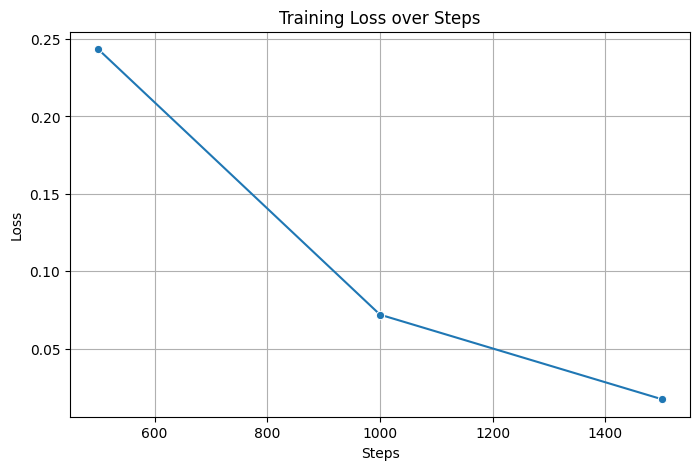

In [30]:
history = trainer.state.log_history

logs_df = pd.DataFrame(trainer.state.log_history)
logs_df.head()

# Filter loss values only
train_loss_df = logs_df.dropna(subset=['loss'])

plt.figure(figsize=(8, 5))
sns.lineplot(x='step', y='loss', data=train_loss_df, marker="o")
plt.title("Training Loss over Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


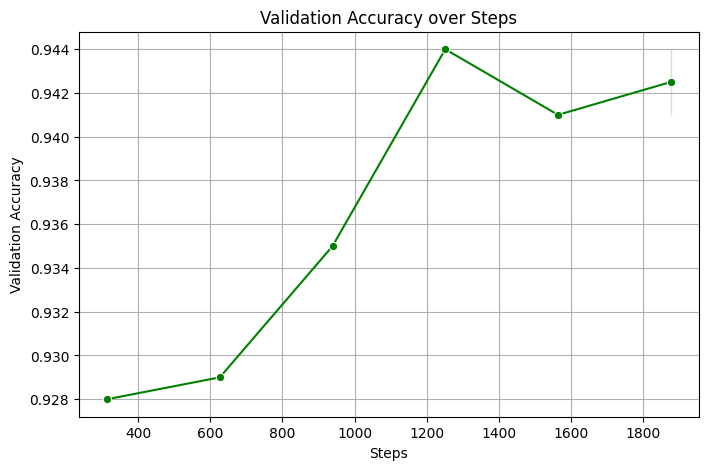

In [31]:
# Filter eval accuracy values only
eval_acc_df = logs_df.dropna(subset=['eval_accuracy'])

plt.figure(figsize=(8, 5))
sns.lineplot(x='step', y='eval_accuracy', data=eval_acc_df, marker="o", color="green")
plt.title("Validation Accuracy over Steps")
plt.xlabel("Steps")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

**Save Fine-tuned Model**

In [32]:
model.save_pretrained("./my_finetuned_model")
tokenizer.save_pretrained("./my_finetuned_model")

('./my_finetuned_model/tokenizer_config.json',
 './my_finetuned_model/special_tokens_map.json',
 './my_finetuned_model/vocab.txt',
 './my_finetuned_model/added_tokens.json',
 './my_finetuned_model/tokenizer.json')

**Deployment**

In [33]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=256)
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=-1).item()

    if prediction == 1:
        return "Positive 👍"
    else:
        return "Negative 👎"

iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=3, placeholder="Type a Yelp review here..."),
    outputs="text",
    title="Yelp Review Sentiment Classifier",
    description="Enter a review and I'll tell you if it's Positive or Negative!"
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://6722a6744ab8ffac35.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
